In [10]:
import pandas as pd
import numpy as np
import re
import glob

def clean_columns(f):
    return '.'.join(f.split('/')[-1].split('_')[:1])

files = [
    '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/mmTreg.Bulk.00hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt',
    '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/mmTreg.Bulk.02hr_vs_mmTh0.Bulk.02hr.with_genes.sig_DE.txt',
    '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/mmTreg.Bulk.16hr_vs_mmTh0.Bulk.16hr.with_genes.sig_DE.txt',
    '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/mmTreg.Bulk.24hr_vs_mmTh0.Bulk.24hr.with_genes.sig_DE.txt',
    '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/mmTreg.Bulk.48hr_vs_mmTh0.Bulk.48hr.with_genes.sig_DE.txt',
    '/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/mmTreg.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.sig_DE.txt'
]

#sig_genes = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/mmTreg.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.sig_DE.txt', sep='\t')

df = None
for file in files:
    df_tmp = pd.read_csv(file, sep='\t')
    if 'stat' in df_tmp.columns.tolist():
        df_tmp.drop(columns = ['Unnamed: 0', 'baseMean', 'lfcSE', 'pvalue', 'padj', 'GeneType', 'stat'], inplace = True)
    else:
        df_tmp.drop(columns = ['Unnamed: 0', 'baseMean', 'lfcSE', 'pvalue', 'padj', 'GeneType'], inplace = True)
        
    df_tmp = df_tmp[['GeneName', 'log2FoldChange']]
    df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_columns(file)]
    if df is None:
        df = df_tmp
    else:
        df = df.merge(df_tmp, how = 'outer', on = 'GeneName')
    
df = df[['GeneName','mmTreg.Bulk.00hr','mmTreg.Bulk.02hr','mmTreg.Bulk.16hr','mmTreg.Bulk.24hr','mmTreg.Bulk.48hr','mmTreg.Sorted.72hr']]
df.columns = [u'gene','00','02','16','24','48','72']
df = df.fillna(0)

df.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/mmTreg.logFC.txt', sep='\t', index=False)


In [1]:
!head /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/mmTreg.logFC.txt

gene	00	02	16	24	48	72
Synj2	2.0846153144632598	1.65016737429171	1.59064753784125	0.9182268565385008	0.325377282777479	0.0
Rell1	1.78461070610793	1.2499214075273999	1.53322137036181	1.21813468872868	1.52488882374435	2.01054147976076
5830416I19Rik	5.46248019059466	0.0	0.0	0.0	0.0	0.0
Lman2l	-1.01302300779588	0.0	0.0	0.0	0.0	0.25100211412738604
Rab4a	-2.1972679137844	0.0	-1.89249153544474	-2.17028428449077	-2.47880360745146	-3.02939682437372
Gm26917	-0.682444066580127	0.0	0.0	0.0	0.0	-0.492897085042563
Camk2b	-1.23080468717329	0.0	0.0	0.0	-1.8486876070825704	-0.5344412536580371
Ccdc22	1.47980372717612	0.0	1.76726118152143	1.49235011459948	1.50467280304174	0.752612685180856
Mtus1	-5.06755589414475	0.0	0.0	0.0	0.0	0.0


In [6]:
!mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples

In [7]:
#### do not run this block again after running the dp_gp since the shuffling is random, each time this code is run,
#### the files generated changes; 

import pandas as pd
import numpy as np

Treg_logFC = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/mmTreg.logFC.txt', sep='\t')

s1 = Treg_logFC.sample(frac=1)
s2 = np.array_split(s1, 7)

for i in range(0,len(s2)):
    Treg_random_tmp = s2[i]
    Treg_random_tmp.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_%s.txt'%i, sep='\t', index=None)



In [1]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/
source /data/reddylab/software/miniconda2/bin/activate alex
sbatch -p all \
    --array=0-3 \
    --mem=64G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/Treg_dp_gp.%a.out \
    <<'EOF'
#!/bin/sh
module load gcc
#SBATCH --cpus-per-task=6
#SBATCH --mem=64G
names=( \ 
     Treg_random_sample_4 \
     Treg_random_sample_5 \
     Treg_random_sample_6 \
)
name=${names[${SLURM_ARRAY_TASK_ID}]}
outfile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/${name}.alpha_0.05.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/${name}.txt"
DP_GP_cluster.py \
--alpha 0.05 \
--unscaled \
--true_times \
-i ${infile} \
-o ${outfile} \
-p png \
--plot \
EOF

Submitted batch job 26542157


In [42]:
import pandas as pd
import numpy as np

spGenes = ['Ctla', 'Stat3', 'Stat5', 'Il10', 'Eomes', 'Runx1', 'Il21ra', 'Il7r', 'Foxp3']

Treg_logFC = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/mmTreg.logFC.txt', sep='\t')
Treg_logFC
### remove rows with all values=0

# numcols = Treg_logFC.dtypes == np.float64
# I = np.sum((Treg_logFC.loc[:,numcols]) != 0,axis = 1) != 0
# Treg_logFC_nonzero = Treg_logFC[I]

### logFC values for the genes of interest

Treg_logFC_spGenes = Treg_logFC[Treg_logFC['gene'].isin(spGenes)]
Treg_logFC_spGenes = Treg_logFC_spGenes.reset_index().drop(columns='index')
t_Treg_logFC_spGenes = Treg_logFC_spGenes.set_index('gene').T
t_Treg_logFC_spGenes



gene,Il7r,Stat3,Runx1,Foxp3,Eomes
00,0.371128,0.000000,0.000000,0.000000,0.000000
02,0.000000,-0.283811,0.000000,0.000000,0.000000
16,0.553095,0.585040,1.742499,4.769613,0.000000
24,0.000000,0.653488,1.015885,4.579361,0.000000
48,0.403082,0.364515,0.350512,7.911284,0.000000
72,-1.610144,0.751484,0.445013,8.064827,-0.906799


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


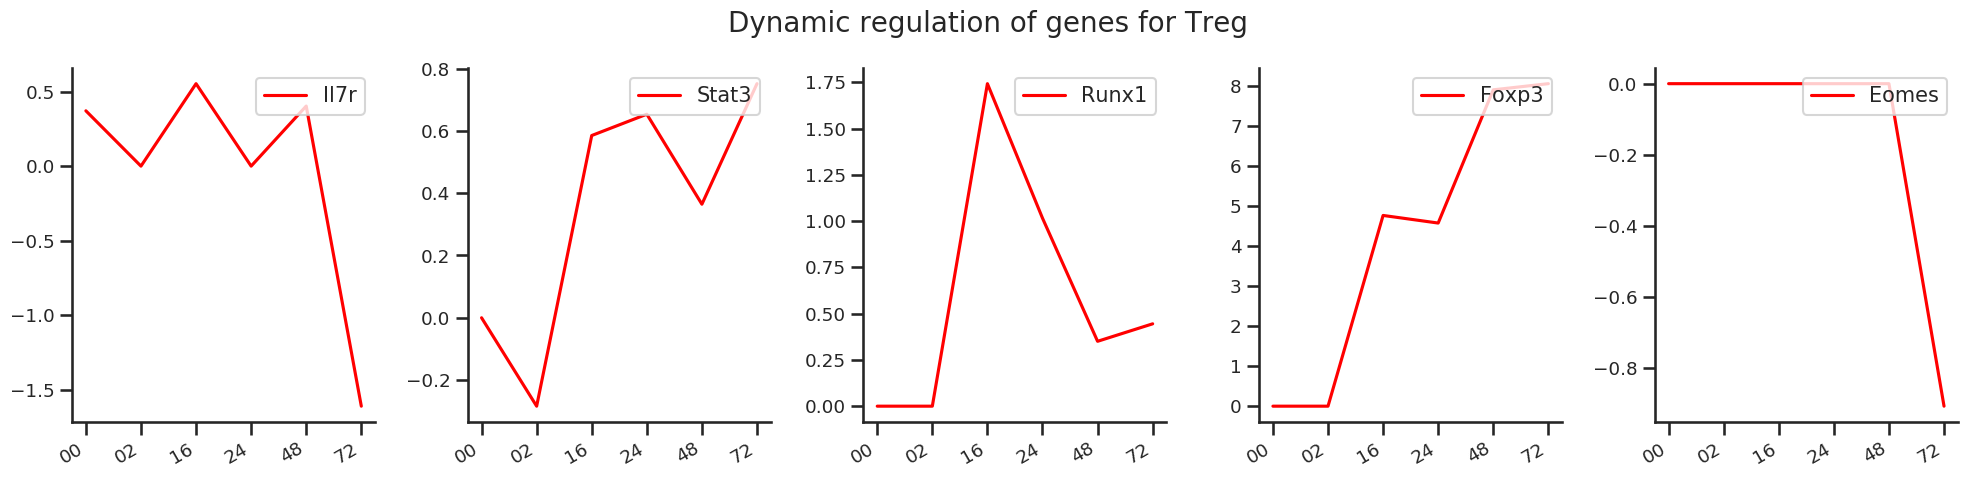

In [46]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
import numpy as np
%matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.8)
plt.rcParams.update({'figure.figsize':(20,9),'figure.dpi':100})

t_Treg_logFC_spGenes.plot(kind='line', subplots=True, grid=False,
        layout=(2,5), sharex=True, sharey=False, legend=False,
        style=['r', 'r', 'r', 'r', 'r', 'b', 'b', 'b', 'b', 'b'],
        xticks=np.arange(0, len(t_Treg_logFC_spGenes)))

## edit the legends
[ax.legend(loc=1, prop={'size':15}) for ax in plt.gcf().axes]

## add x and y-labels

#[ax.set_ylabel('log2FC') for ax in plt.gcf().axes]

plt.gcf().tight_layout(rect=[0, 0.03, 1, 0.95])
plt.gcf().suptitle("Dynamic regulation of genes for Treg", fontsize=20)

sns.despine()
#plt.savefig('/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/clustering/Th17/plots/Th17_sp_genes_dynamic_regulation_before_normalization_with72sorted.pdf')
plt.show()

In [21]:
!wc -l /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/mmTreg.logFC.txt

7764 /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/mmTreg.logFC.txt


#### Min-max normalization

In [24]:
import pandas as pd
import numpy as np
import os
import glob

files = [f for f in glob.glob('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/*.log2fc_DP_GP_optimal_clustering.txt')]
Treg_logFC = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/mmTreg.logFC.txt', sep='\t')

numcols = Treg_logFC.dtypes == np.float64
I = np.sum((Treg_logFC.loc[:,numcols]) != 0,axis = 1) != 0
Treg_logFC_nonzero = Treg_logFC[I]

for file in files:
    df_tmp = pd.read_csv(file, sep='\t')
    head, tail = os.path.split(file)
    filename = tail.split(".")[0]
    Treg_cluster_logFC = df_tmp.merge(Treg_logFC_nonzero, on='gene', how='inner')
    Treg_new_cluster_log2FC_min_max = Treg_cluster_logFC.groupby('cluster').agg(['min','max'])
    Treg_new_cluster_log2FC_min_max.drop(columns='gene', inplace=True)
    Treg_new_merged = Treg_cluster_logFC.merge(Treg_new_cluster_log2FC_min_max, on='cluster', how='inner')
    Treg_new_merged['norm_00'] = (Treg_new_merged['00'])/(Treg_new_merged[('00', 'max')] - Treg_new_merged[('00', 'min')])
    Treg_new_merged['norm_02'] = (Treg_new_merged['02'])/(Treg_new_merged[('02', 'max')] - Treg_new_merged[('02', 'min')])
    Treg_new_merged['norm_16'] = (Treg_new_merged['16'])/(Treg_new_merged[('16', 'max')] - Treg_new_merged[('16', 'min')])
    Treg_new_merged['norm_24'] = (Treg_new_merged['24'])/(Treg_new_merged[('24', 'max')] - Treg_new_merged[('24', 'min')])
    Treg_new_merged['norm_48'] = (Treg_new_merged['48'])/(Treg_new_merged[('48', 'max')] - Treg_new_merged[('48', 'min')])
    Treg_new_merged['norm_72'] = (Treg_new_merged['72'])/(Treg_new_merged[('72', 'max')] - Treg_new_merged[('72', 'min')])
    Treg_new_normalized = Treg_new_merged[['gene','norm_00','norm_02','norm_16','norm_24','norm_48','norm_72']]
    Treg_new_normalized.rename(columns={'norm_00':'00','norm_02':'02','norm_16':'16',
                                        'norm_24':'24','norm_48':'48','norm_72':'72'}, inplace=True)
    Treg_new_normalized.replace([np.inf, -np.inf], np.nan, inplace=True)
    Treg_new_normalized = Treg_new_normalized.dropna()
    numcols = Treg_new_normalized.dtypes == np.float64
    K = np.sum((Treg_new_normalized.loc[:,numcols]) != 0,axis = 1) != 0
    Treg_new_normalized_nozero = Treg_new_normalized[K]
    Treg_new_normalized_nozero.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/%s_min_max_norm_from_DP_GP.txt' % (filename), sep='\t', index=None)
    


/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/pandas/core/reshape/merge.py:543: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/pandas/core/frame.py:3795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [18]:
sum((np.sum(Treg_logFC.loc[:,numcols],axis=1))==0)

0

In [25]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max
source /data/reddylab/software/miniconda2/bin/activate alex
sbatch -p all \
    --mem=32G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/Treg_min_max_dp_gp_v1.out \
    <<'EOF'
#!/bin/sh
module load gcc
outfile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max/Treg_random_sample_6_min_max_norm_from_DP_GP.alpha_0.05.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_6_min_max_norm_from_DP_GP.txt"
DP_GP_cluster.py \
--alpha 0.05 \
--unscaled \
--true_times \
-i ${infile} \
-o ${outfile} \
-p png \
--plot \
EOF

Submitted batch job 26599049


In [26]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max
source /data/reddylab/software/miniconda2/bin/activate alex
sbatch -p all \
    --mem=32G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/Treg_min_max_dp_gp_v2.out \
    <<'EOF'
#!/bin/sh
module load gcc
outfile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max/Treg_random_sample_5_min_max_norm_from_DP_GP.alpha_0.05.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_5_min_max_norm_from_DP_GP.txt"
DP_GP_cluster.py \
--alpha 0.05 \
--unscaled \
--true_times \
-i ${infile} \
-o ${outfile} \
-p png \
--plot \
EOF

Submitted batch job 26599050


In [27]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max
source /data/reddylab/software/miniconda2/bin/activate alex
sbatch -p all \
    --mem=32G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/Treg_min_max_dp_gp_v3.out \
    <<'EOF'
#!/bin/sh
module load gcc
outfile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max/Treg_random_sample_4_min_max_norm_from_DP_GP.alpha_0.05.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_4_min_max_norm_from_DP_GP.txt"
DP_GP_cluster.py \
--alpha 0.05 \
--unscaled \
--true_times \
-i ${infile} \
-o ${outfile} \
-p png \
--plot \
EOF

Submitted batch job 26599051


In [28]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max
source /data/reddylab/software/miniconda2/bin/activate alex
sbatch -p all \
    --mem=32G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/Treg_min_max_dp_gp_v4.out \
    <<'EOF'
#!/bin/sh
module load gcc
outfile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max/Treg_random_sample_3_min_max_norm_from_DP_GP.alpha_0.05.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_3_min_max_norm_from_DP_GP.txt"
DP_GP_cluster.py \
--alpha 0.05 \
--unscaled \
--true_times \
-i ${infile} \
-o ${outfile} \
-p png \
--plot \
EOF

Submitted batch job 26599052


In [29]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max
source /data/reddylab/software/miniconda2/bin/activate alex
sbatch -p all \
    --mem=32G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/Treg_min_max_dp_gp_v5.out \
    <<'EOF'
#!/bin/sh
module load gcc
outfile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max/Treg_random_sample_2_min_max_norm_from_DP_GP.alpha_0.05.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_2_min_max_norm_from_DP_GP.txt"
DP_GP_cluster.py \
--alpha 0.05 \
--unscaled \
--true_times \
-i ${infile} \
-o ${outfile} \
-p png \
--plot \
EOF

Submitted batch job 26599053


In [30]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max
source /data/reddylab/software/miniconda2/bin/activate alex
sbatch -p all \
    --mem=32G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/Treg_min_max_dp_gp_v6.out \
    <<'EOF'
#!/bin/sh
module load gcc
outfile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max/Treg_random_sample_1_min_max_norm_from_DP_GP.alpha_0.05.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_1_min_max_norm_from_DP_GP.txt"
DP_GP_cluster.py \
--alpha 0.05 \
--unscaled \
--true_times \
-i ${infile} \
-o ${outfile} \
-p png \
--plot \
EOF

Submitted batch job 26599054


In [31]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max
source /data/reddylab/software/miniconda2/bin/activate alex
sbatch -p all \
    --mem=32G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/Treg_min_max_dp_gp_v7.out \
    <<'EOF'
#!/bin/sh
module load gcc
outfile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max/Treg_random_sample_0_min_max_norm_from_DP_GP.alpha_0.05.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_0_min_max_norm_from_DP_GP.txt"
DP_GP_cluster.py \
--alpha 0.05 \
--unscaled \
--true_times \
-i ${infile} \
-o ${outfile} \
-p png \
--plot \
EOF

Submitted batch job 26599055


In [32]:
%%bash
ls /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/*_min_max_norm_from_DP_GP.txt

/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_min_max_norm_from_DP_GP.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_0_min_max_norm_from_DP_GP.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_1_min_max_norm_from_DP_GP.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_2_min_max_norm_from_DP_GP.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_3_min_max_norm_from_DP_GP.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_4_min_max_norm_from_DP_GP.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_5_min_max_norm_from_DP_GP.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_6_min_

### dynamic regulation of genes after the min-max normalization

In [7]:
%%bash
cd /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/
cat Treg_random_sample_0.txt \
    Treg_random_sample_1.txt \
    Treg_random_sample_2.txt \
    Treg_random_sample_3.txt \
    Treg_random_sample_4.txt \
    Treg_random_sample_5.txt \
    Treg_random_sample_6.txt | grep 'Il17a'

Il17a	0.0	0.0	0.0	0.0	3.25057482079741	0.0


In [11]:
%%bash
cd /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/
cat Treg_random_sample_0_min_max_norm_from_DP_GP.txt \
    Treg_random_sample_1_min_max_norm_from_DP_GP.txt \
    Treg_random_sample_2_min_max_norm_from_DP_GP.txt \
    Treg_random_sample_3_min_max_norm_from_DP_GP.txt \
    Treg_random_sample_4_min_max_norm_from_DP_GP.txt \
    Treg_random_sample_5_min_max_norm_from_DP_GP.txt \
    Treg_random_sample_6_min_max_norm_from_DP_GP.txt | grep 0

gene	00	02	16	24	48	72
1110008F13Rik	0.36328298078988164	0.5488419845437124	0.5172743131288197	0.5802237506501443	0.6201156273855316	0.2193892333061198
2510039O18Rik	0.36328298078988164	0.5488419845437124	0.5172743131288197	0.5802237506501443	0.51801661963259	0.2193892333061198
AI314180	0.36328298078988164	0.5488419845437124	0.5172743131288197	0.35502544353833043	0.3463995501160258	0.4589640235559193
AI413582	0.36328298078988164	0.5488419845437124	0.5172743131288197	0.5802237506501443	0.7411490889370236	0.2193892333061198
Aacs	0.36328298078988164	0.5488419845437124	0.5172743131288197	0.5802237506501443	0.3463995501160258	0.9377377060283639
Aaed1	0.36328298078988164	0.5488419845437124	0.5172743131288197	0.5802237506501443	0.3463995501160258	0.6886299191412646
Ablim1	0.36328298078988164	0.23445841769750553	0.5172743131288197	0.5802237506501443	0.9683509029709239	0.660561734017943
Acaa1a	0.36328298078988164	0.5488419845437124	0.5172743131288197	0.5802237506501443	0.5433276143051461	0.5484

In [19]:
%%bash
cd /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/
cat Treg_random_sample_0_min_max_norm_from_DP_GP.txt \
    Treg_random_sample_1_min_max_norm_from_DP_GP.txt \
    Treg_random_sample_2_min_max_norm_from_DP_GP.txt \
    Treg_random_sample_3_min_max_norm_from_DP_GP.txt \
    Treg_random_sample_4_min_max_norm_from_DP_GP.txt \
    Treg_random_sample_5_min_max_norm_from_DP_GP.txt \
    Treg_random_sample_6_min_max_norm_from_DP_GP.txt > Treg_min_max_norm_from_DP_GP.txt

In [22]:
!wc -l /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_min_max_norm_from_DP_GP.txt

6531 /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_min_max_norm_from_DP_GP.txt


In [20]:
import pandas as pd

Treg_min_max_genes = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_min_max_norm_from_DP_GP.txt', sep='\t')
spGenes=['Maf', 'Il17a', 'Rorc', 'Stat3', 'Stat5', 'Batf', 'Irf4', 'Runx1', 'Il21r', 'Tbx21', 'Foxp3']
Treg_min_max_Spgenes = Treg_min_max_genes[Treg_min_max_genes['gene'].isin(spGenes)]
Treg_min_max_Spgenes = Treg_min_max_Spgenes.reset_index().drop(columns='index')
t_Treg = Treg_min_max_Spgenes.set_index('gene').T
t_Treg

gene,Il21r,Batf,Irf4,Maf,Tbx21,Rorc,Stat3
00,1.000000,1.000000,0.512371,1.000000,0.000000,1.000000,0.000000
02,0.734807,0.603363,0.680648,1.000000,0.429132,1.000000,0.165144
16,0.526370,0.366010,0.600842,1.000000,0.434776,1.000000,0.391753
24,0.575465,0.000000,0.383211,1.000000,0.360980,0.333576,0.408906
48,0.526146,0.227334,0.517245,0.821528,0.907083,0.739290,0.271165
72,0.894203,0.384411,0.345427,0.796226,0.913317,0.773324,0.366239


No handles with labels found to put in legend.


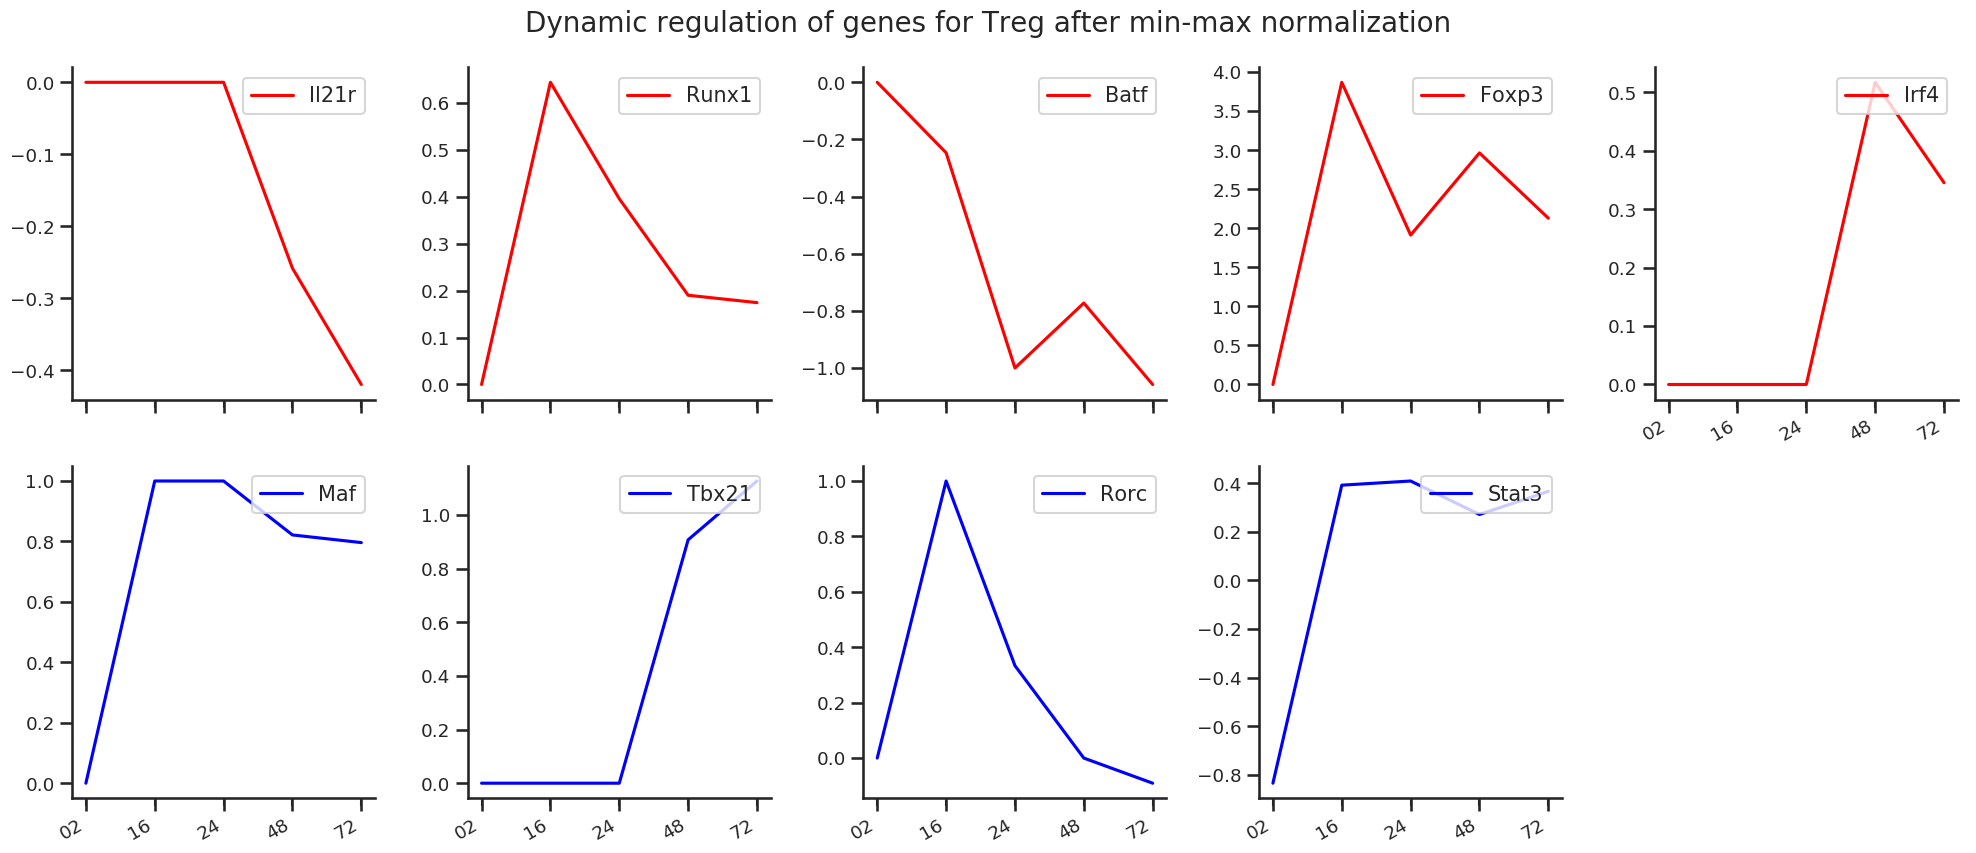

In [9]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
import numpy as np
%matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.8)
plt.rcParams.update({'figure.figsize':(20,9),'figure.dpi':100})

t_Treg.plot(kind='line', subplots=True, grid=False,
        layout=(2,5), sharex=True, sharey=False, legend=False,
        style=['r', 'r', 'r', 'r', 'r', 'b', 'b', 'b', 'b', 'b'],
        xticks=np.arange(0, len(t_Treg)))

## edit the legends
[ax.legend(loc=1, prop={'size':15}) for ax in plt.gcf().axes]

## add x and y-labels

#[ax.set_ylabel('log2FC') for ax in plt.gcf().axes]

plt.gcf().tight_layout(rect=[0, 0.03, 1, 0.95])
plt.gcf().suptitle("Dynamic regulation of genes for Treg after min-max normalization", fontsize=20)

sns.despine()
#plt.savefig('/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/clustering/Th17/plots/Th17_sp_genes_dynamic_regulation_before_normalization_with72sorted.pdf')
plt.show()

In [23]:
import glob
import pandas as pd
import os

optimal_cluster = [f for f in glob.glob('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max/*_min_max_norm_from_DP_GP.alpha_0.05.log2fc_DP_GP_optimal_clustering.txt')]
min_max_norm_logFC = [f for f in glob.glob('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/*_min_max_norm_from_DP_GP.txt')]

min_max_df = None
for file in min_max_norm_logFC:
    tmp_df = pd.read_csv(file, sep='\t')
    if min_max_df is None:
        min_max_df = tmp_df
    else:
        min_max_df = pd.concat([min_max_df, tmp_df])

min_max_df.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_allGenes_logFC_min_max_norm_from_DP_GP.txt', sep='\t')

min_max_df[min_max_df.gene=='Maf']


,gene,00,02,16,24,48,72
880,Maf,0.0,0.0,1.0,1.0,0.821528,0.796226
4634,Maf,1.0,1.0,1.0,1.0,0.821528,0.796226


In [10]:
def samp_num(file):
    head, tail = os.path.split(file)
    filename = tail.split(".")[0]
    sample = filename.split("_")[3]
    return sample

In [24]:
df = None
for file in optimal_cluster:
    df_tmp = pd.read_csv(file, sep='\t')
    df_tmp['sample'] = samp_num(file)
    if df is None:
        df = df_tmp
    else:
        df = pd.concat([df, df_tmp])
        


df_merged = df.merge(min_max_df, on='gene', how='inner')
df_merged[df_merged.gene=='Maf']
# df_merged['sample'] = df_merged['sample'].astype('int64')
# df_merged['sample_cluster'] = 's'+df_merged['sample'].astype('str')+'c'+df_merged['cluster'].astype('str')
# df_merged

,cluster,gene,sample,00,02,16,24,48,72
6226,1,Maf,4,0.0,0.0,1.0,1.0,0.821528,0.796226
6227,1,Maf,4,1.0,1.0,1.0,1.0,0.821528,0.796226


In [16]:
samp3 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/min_max/Treg_random_sample_3_min_max_norm_from_DP_GP.alpha_0.05.log2fc_DP_GP_optimal_clustering.txt', sep='\t')
samp3[samp3.gene=='0610007P14Rik']


,cluster,gene
0,1,0610007P14Rik


In [25]:
!cat /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_4_min_max_norm_from_DP_GP.txt | grep 'Maf'


Mafg	0.0	0.0	0.0	0.0	0.3744229093710539	0.8002800325925585
Maf	0.0	0.0	1.0	1.0	0.8215277124539779	0.7962257752606854


### K-Means Clustering

In [50]:
import pandas as pd

Treg_min_max_genes = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_min_max_norm_from_DP_GP.txt', sep='\t')
X = Treg_min_max_genes
y = Treg_min_max_genes['gene']

In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X['gene'] = le.fit_transform(X['gene'])
y = le.transform(y)

In [53]:
X.head()

,gene,00,02,16,24,48,72
0,3,0.363283,0.548842,0.517274,0.580224,0.620116,0.219389
1,60,0.363283,0.548842,0.517274,0.580224,0.518017,0.219389
2,146,0.363283,0.548842,0.517274,0.355025,0.346400,0.458964
3,147,0.363283,0.548842,0.517274,0.580224,0.741149,0.219389
4,163,0.363283,0.548842,0.517274,0.580224,0.346400,0.937738


In [54]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=12)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [55]:
kmeans.cluster_centers_

array([[2.69500000e+02, 5.54573221e-01, 5.07213504e-01, 5.22227679e-01,
        5.09642380e-01, 5.13134558e-01, 4.98347635e-01],
       [4.58800000e+03, 5.65557345e-01, 5.35351957e-01, 5.12533502e-01,
        5.07799401e-01, 4.87651578e-01, 5.13323559e-01],
       [2.43350000e+03, 5.44066631e-01, 5.46390490e-01, 5.04450481e-01,
        5.03770362e-01, 5.01823619e-01, 5.04923517e-01],
       [6.23690090e+03, 5.32097328e-01, 4.98834861e-01, 6.88683166e-01,
        7.62713237e-01, 1.01954278e+00, 1.27094973e+00],
       [1.34679354e+03, 5.65555414e-01, 5.00722259e-01, 5.09151951e-01,
        5.21748289e-01, 5.12319829e-01, 4.91444477e-01],
       [3.50900000e+03, 5.51891314e-01, 4.92230308e-01, 5.22658310e-01,
        5.24086932e-01, 5.16355130e-01, 5.10481591e-01],
       [5.68350000e+03, 5.40567093e-01, 5.01627422e-01, 5.15254204e-01,
        5.19260375e-01, 5.23366545e-01, 4.96182438e-01],
       [8.09000000e+02, 5.44787207e-01, 5.08085801e-01, 5.10676961e-01,
        5.27358719e-01, 5

In [56]:
kmeans.n_iter_

35

In [57]:
labels = kmeans.labels_

# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

Result: 1 out of 6530 samples were correctly labeled.


#### Elbow method to find the optimal number of clusters

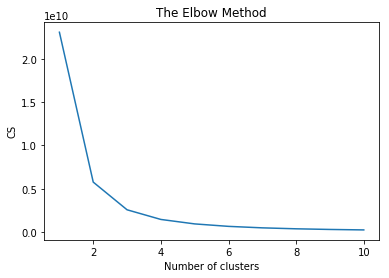

In [59]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline

cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [64]:
kmeans = KMeans(n_clusters=4, random_state=4)

kmeans.fit(X)

# check how many of the samples were correctly labeled
labels = kmeans.labels_

correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 1 out of 6530 samples were correctly labeled.
Accuracy score: 0.00


In [23]:
!ls /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/*.log2fc_DP_GP_optimal_clustering.txt

/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/Treg_random_sample_0.alpha_0.05.log2fc_DP_GP_optimal_clustering.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/Treg_random_sample_1.alpha_0.05.log2fc_DP_GP_optimal_clustering.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/Treg_random_sample_2.alpha_0.05.log2fc_DP_GP_optimal_clustering.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/Treg_random_sample_3.alpha_0.05.log2fc_DP_GP_optimal_clustering.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/Treg_random_sample_4.alpha_0.05.log2fc_DP_GP_optimal_clustering.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/Treg_random_sample_5.alpha_0.05.log2fc_DP_GP_optimal_clustering.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/Treg_random_sample_6.alpha_0.05.log2fc_DP_GP_optimal_clustering.txt


### DP_GP: different varations

* DP_GP separately for upregulated and downregulated genes with logFC
* DP_GP for a set of genes in the list of DE genes with their TPM values

#### DP_GP for (protein coding genes from Treg_random_sample_5 + the specific genes of interest) with their TPM values

In [7]:
!ls /data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg*.72h.*.rsem.genes.results



/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_bulk.72h.rep1.star2.rsem.genes.results
/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_bulk.72h.rep2.star2.rsem.genes.results
/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_bulk.72h.rep3.star2.rsem.genes.results
/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_bulk.72h.rep4.star2.rsem.genes.results
/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep1.star2.rsem.genes.results
/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep2.star2.rsem.genes.results
/data/reddyl

In [1]:
import pandas as pd
import re

tpm_files = {
    'mmTreg.00hr':[
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep1.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep2.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep3.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep4.star2.rsem.genes.results'
    ],
    
    'mmTreg.02hr':[
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep2.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep3.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep4.star2.rsem.genes.results'   
    ],
    
    'mmTreg.16hr':[
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep2.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep3.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep4.star2.rsem.genes.results'
    ],
    
    'mmTreg.24hr':[
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep1.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep2.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep3.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep4.star2.rsem.genes.results'  
    ],
    
    'mmTreg.48hr':[
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep1.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep2.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep3.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep4.star2.rsem.genes.results'  
    ],
    
    'mmTreg.72hr':[
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep1.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep2.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep3.star2.rsem.genes.results',
     '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep4.star2.rsem.genes.results'
    ]
    
}

ref_gene = pd.read_csv('/data/reddylab/Reference_Data/Gencode/vM13/gencode.vM13.gene_id_to_gene_name.txt', sep='\t', names=['ensembl_id', 'gene_name', 'gene_type'])
#gencode_annotation = pd.read_csv('/data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.bed', sep='\t', names=['chr','start','end','ENS_ID','score','strand','gene_name','GeneType'])

def column_name(s):
    name = '.'.join(s.split('/')[-1].split('.')[:5])
    return name

avg_tpm_df=None
for tpm, files in tpm_files.items():
    df=None
    for file in files:
        df_tmp = pd.read_csv(file, sep='\t')
        df_tmp.columns = df_tmp.columns[:-2].tolist() + [column_name(file)] + df_tmp.columns[-1:].tolist()
        if df is None:
            df = df_tmp.loc[:, ['gene_id'] + [df_tmp.columns[-2]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-2]], how='right')
            
    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='float')
    df['%s.mean' % tpm] = df.iloc[:,1:5].mean(axis=1)
    df['%s.mean' % tpm] = df['%s.mean' % tpm].round(2)
    df = df[['gene_id','%s.mean' % tpm]]
    if avg_tpm_df is None:
        avg_tpm_df = df
    else:
        avg_tpm_df = avg_tpm_df.merge(df, on='gene_id', how='outer')
    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='float')
        
tpm_df_with_gene = avg_tpm_df.merge(ref_gene, left_on='gene_id', right_on='ensembl_id', how='left')  
tpm_df_with_gene = tpm_df_with_gene[tpm_df_with_gene.gene_type=='protein_coding']
tpm_df_with_gene = tpm_df_with_gene[['gene_name','mmTreg.00hr.mean','mmTreg.02hr.mean','mmTreg.16hr.mean','mmTreg.24hr.mean','mmTreg.48hr.mean','mmTreg.72hr.mean']]
tpm_df_with_gene


,gene_name,mmTreg.00hr.mean,mmTreg.02hr.mean,mmTreg.16hr.mean,mmTreg.24hr.mean,mmTreg.48hr.mean,mmTreg.72hr.mean
0,Gnai3,77.22,151.35,77.21,78.18,88.22,65.24
1,Pbsn,0.00,0.00,0.00,0.00,0.00,0.00
2,Cdc45,2.77,2.42,59.29,114.82,78.79,62.03
4,Scml2,0.11,0.08,0.53,1.12,0.51,0.53
5,Apoh,0.02,0.03,0.01,0.06,0.05,0.15
6,Narf,20.97,1.57,7.05,8.51,17.69,22.83
7,Cav2,0.00,0.01,0.02,0.10,0.97,1.78
8,Klf6,43.80,26.14,21.08,32.01,63.10,50.02
9,Scmh1,14.20,13.59,12.42,16.81,10.31,12.28
10,Cox5a,114.20,163.45,365.30,415.72,470.54,472.23


In [2]:
import numpy as np

Treg_sample5 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_random_samples/Treg_random_sample_5.txt', sep='\t')
Treg_sample5_gene_list = Treg_sample5.gene.tolist()
final_gene_list = Treg_sample5_gene_list + ['Ctla', 'Stat3', 'Stat5', 'Il10', 'Eomes', 'Runx1', 'Il21ra', 'Il7r', 'Foxp3']


tmp_df_with_gene_from_list = tpm_df_with_gene[tpm_df_with_gene.gene_name.isin(final_gene_list)]

### check if there are columns with the entire row of TPMs equal to zero, if so remove it

numcols = tmp_df_with_gene_from_list.dtypes == np.float64
I = np.sum((tmp_df_with_gene_from_list.loc[:,numcols]) != 0,axis = 1) != 0
tmp_df_with_gene_from_list_nonzero = tmp_df_with_gene_from_list[I]
tmp_df_with_gene_from_list_nonzero.columns = [u'gene','00','02','16','24','48','72']




#tmp_df_with_gene_from_list_nonzero.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_sample_5_with_TPM.txt', sep='\t', index=False)

In [3]:
tmp_df_with_gene_from_list_nonzero.describe()

,00,02,16,24,48,72
count,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,92.919092,87.378539,88.969007,87.246142,90.194532,93.772079
std,460.941605,411.028048,344.505251,315.620129,314.512834,378.664729
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4.995000,2.540000,4.912500,5.662500,7.072500,8.110000
50%,21.985000,15.065000,19.590000,21.495000,23.800000,22.145000
75%,58.182500,53.842500,61.925000,63.752500,66.460000,60.160000
max,9825.100000,8486.380000,5269.130000,5075.320000,4636.070000,5518.350000


In [4]:
tmp_df_with_gene_from_list_nonzero[tmp_df_with_gene_from_list_nonzero <2].dropna()

,gene,00,02,16,24,48,72
670,Col5a3,0.01,0.00,0.00,0.01,0.23,0.32
714,Gab2,0.04,0.04,0.02,0.09,0.88,1.84
840,Nid1,0.02,0.00,0.00,0.06,0.78,0.73
1063,Sulf2,0.24,0.07,0.53,1.02,1.66,1.00
1715,Pls3,0.16,0.04,0.23,0.43,0.94,1.77
1734,Il10,0.00,0.31,0.01,0.09,0.05,0.16
2069,Rps6kl1,0.57,0.20,1.06,0.65,0.92,0.58
2111,Cyb561,0.21,0.16,0.92,0.94,0.77,1.24
2303,H2afy2,0.00,0.00,0.00,0.06,0.30,0.76
2361,Rab36,0.10,0.03,0.10,0.10,0.26,0.32


In [5]:
tmp_df_with_gene_from_list_nonzero_tpm = tmp_df_with_gene_from_list_nonzero[tmp_df_with_gene_from_list_nonzero < 2].dropna()

tmp_df_with_gene_from_list_nonzero_tpm_list = tmp_df_with_gene_from_list_nonzero_tpm['gene'].tolist()

tmp_df_with_gene_from_list_nonzero_tpm_filtered = tmp_df_with_gene_from_list_nonzero[~tmp_df_with_gene_from_list_nonzero.gene.isin(tmp_df_with_gene_from_list_nonzero_tpm_list)]
#tmp_df_with_gene_from_list_nonzero[tmp_df_with_gene_from_list_nonzero['gene'] - tmp_df_with_gene_from_list_nonzero_tpm['gene'].astype('str')]
tmp_df_with_gene_from_list_nonzero_tpm_filtered.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_sample_5_with_TPM_filtered.txt', sep='\t', index=False)
                                                       



In [6]:
tmp_df_with_gene_from_list_nonzero_tpm_filtered[tmp_df_with_gene_from_list_nonzero_tpm_filtered.gene=='Fut7']

,gene,00,02,16,24,48,72
10402,Fut7,0.7,0.2,3.5,9.78,30.8,54.93


In [53]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
sbatch -p all \
    --mem=32G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/Treg_sample5_tpm_filtered.out \
    <<'EOF'
#!/bin/sh
module load gcc
outfile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/TPM/Treg_sample_5_with_TPM_filtered.alpha_0.05.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_sample_5_with_TPM_filtered.txt"
DP_GP_cluster.py \
--alpha 0.05 \
--true_times \
-i ${infile} \
-o ${outfile} \
-p png \
--plot \
EOF

Submitted batch job 26620886


Trial: DP_GP with log TPMs

In [13]:
import numpy as np
import pandas as pd 

tmp_df_with_gene_from_list_nonzero_tpm_filtered = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_sample_5_with_TPM_filtered.txt', sep='\t')
tmp_df_with_gene_from_list_nonzero_log_tpm_filtered = tmp_df_with_gene_from_list_nonzero_tpm_filtered.apply(lambda x: np.log10(x) if np.issubdtype(x.dtype, np.number) else x)
tmp_df_with_gene_from_list_nonzero_log_tpm_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)
tmp_df_with_gene_from_list_nonzero_log_tpm_filtered = tmp_df_with_gene_from_list_nonzero_log_tpm_filtered.dropna()



tmp_df_with_gene_from_list_nonzero_log_tpm_filtered.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_sample_5_with_logTPM_filtered.txt', sep='\t', index=None)

/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


In [14]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
sbatch -p all \
    --mem=32G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/Treg_sample5_logtpm_filtered.out \
    <<'EOF'
#!/bin/sh
module load gcc
outfile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/TPM/Treg_sample_5_with_logTPM_filtered.alpha_0.05.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_sample_5_with_logTPM_filtered.txt"
DP_GP_cluster.py \
--alpha 0.05 \
--true_times \
-i ${infile} \
-o ${outfile} \
-p png \
--plot \
EOF

Submitted batch job 26651265


#### Min-max normalization for the DP_GP clusters with TPMs

In [40]:
import pandas as pd
import numpy as np
import os
import glob

Treg_optimal_cluster = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/TPM/Treg_sample_5_with_TPM.alpha_0.05.log2fc_DP_GP_optimal_clustering.txt', sep='\t')
Treg_TPM = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_sample_5_with_TPM.txt', sep='\t')

numcols = Treg_TPM.dtypes == np.float64
I = np.sum((Treg_TPM.loc[:,numcols]) != 0,axis = 1) != 0
Treg_TPM_nonzero = Treg_TPM[I]

Treg_cluster_TPM = Treg_optimal_cluster.merge(Treg_TPM_nonzero, on='gene', how='inner')
Treg_new_cluster_TPM_min_max = Treg_cluster_TPM.groupby('cluster').agg(['min','max'])
Treg_new_cluster_TPM_min_max.drop(columns='gene', inplace=True)
Treg_new_merged = Treg_cluster_TPM.merge(Treg_new_cluster_TPM_min_max, on='cluster', how='inner')
Treg_new_merged['norm_00'] = (Treg_new_merged['00'])/(Treg_new_merged[('00', 'max')] - Treg_new_merged[('00', 'min')])
Treg_new_merged['norm_02'] = (Treg_new_merged['02'])/(Treg_new_merged[('02', 'max')] - Treg_new_merged[('02', 'min')])
Treg_new_merged['norm_16'] = (Treg_new_merged['16'])/(Treg_new_merged[('16', 'max')] - Treg_new_merged[('16', 'min')])
Treg_new_merged['norm_24'] = (Treg_new_merged['24'])/(Treg_new_merged[('24', 'max')] - Treg_new_merged[('24', 'min')])
Treg_new_merged['norm_48'] = (Treg_new_merged['48'])/(Treg_new_merged[('48', 'max')] - Treg_new_merged[('48', 'min')])
Treg_new_merged['norm_72'] = (Treg_new_merged['72'])/(Treg_new_merged[('72', 'max')] - Treg_new_merged[('72', 'min')])
Treg_new_normalized = Treg_new_merged[['gene','norm_00','norm_02','norm_16','norm_24','norm_48','norm_72']]
Treg_new_normalized.rename(columns={'norm_00':'00','norm_02':'02','norm_16':'16',
                                    'norm_24':'24','norm_48':'48','norm_72':'72'}, inplace=True)
Treg_new_normalized.replace([np.inf, -np.inf], np.nan, inplace=True)
Treg_new_normalized = Treg_new_normalized.dropna()
numcols = Treg_new_normalized.dtypes == np.float64
K = np.sum((Treg_new_normalized.loc[:,numcols]) != 0,axis = 1) != 0
Treg_new_normalized_nozero = Treg_new_normalized[K]

Treg_new_normalized_nozero.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_sample5_tpm_min_max_normalized.txt', sep='\t', index=False)



/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/pandas/core/reshape/merge.py:543: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/pandas/core/frame.py:3795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [41]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
sbatch -p all \
    --mem=32G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/Treg_sample5_tpm_min_max.out \
    <<'EOF'
#!/bin/sh
module load gcc
outfile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/results/TPM/Treg_sample_5_with_TPM_min_max_normalized.alpha_0.05.log2fc_DP_GP"
infile="/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/dp_gp/Treg_sample5_tpm_min_max_normalized.txt"
DP_GP_cluster.py \
--alpha 0.05 \
--unscaled \
--true_times \
-i ${infile} \
-o ${outfile} \
-p png \
--plot \
EOF

Submitted batch job 26607621


#### Correlation between replicates

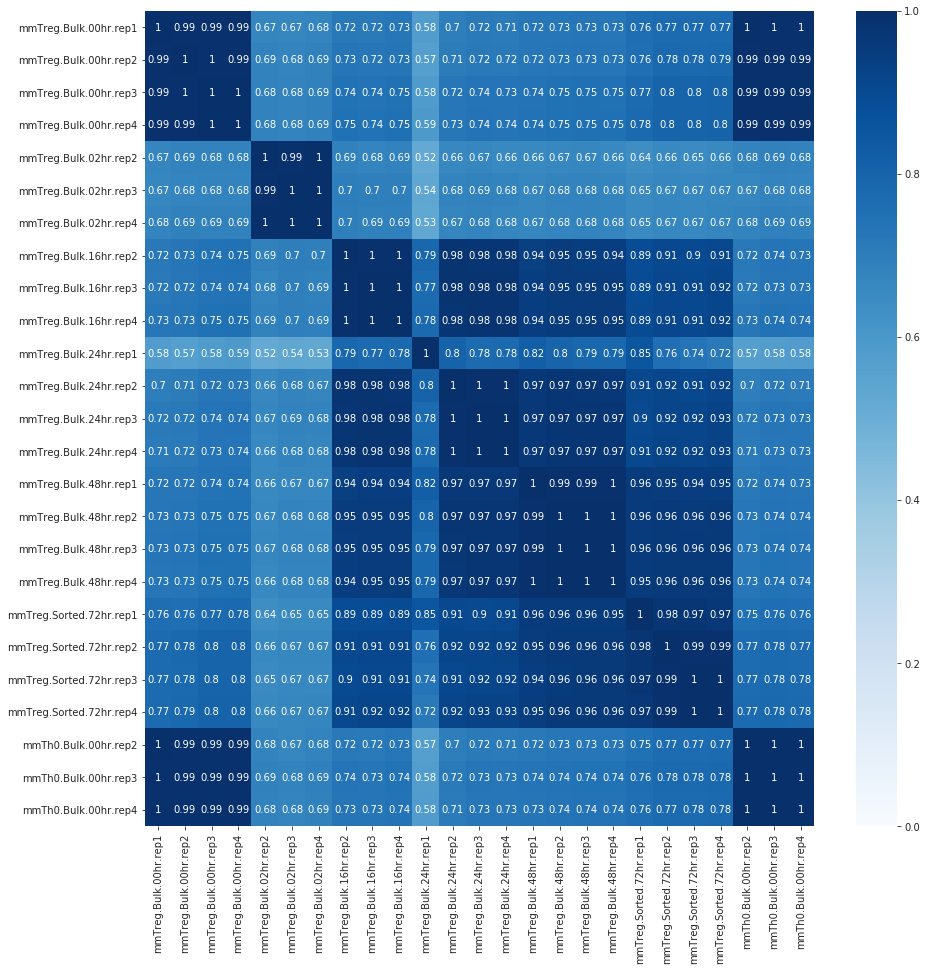

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams['pdf.fonttype'] = 3
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
%matplotlib inline

treg_th0 = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/Treg_Th0.counts.txt', sep='\t')
treg_th0 = treg_th0.drop(columns=['Unnamed: 0','Geneid'])
correlations = treg_th0.corr()

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(correlations, annot=True, cmap='Blues', ax=ax, vmin=0, vmax=1)
plt.savefig('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/correlation_plot_between_replicates.pdf')
plt.show()